In [17]:
import os

#only use GPU 0 
#os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Force CPU use
os.environ["CUDA_VISIBLE_DEVICES"]="1"

#import tensorrt
import tensorflow as tf

In [18]:
import sys
from pathlib import Path
import os
import re
import pickle
import numpy as np

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import cv2

import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh

from sklearn.model_selection import train_test_split
from skimage.transform import resize
from skimage.io import imread
import sklearn.metrics
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
import argparse
import locale


import os

HOME = Path('/home/peregrin/Desktop')

data_base_dir = HOME / 'CNN-main/Input'
Path_to_folder = HOME / 'CNN-main'



In [19]:
print('Collecting data from {}:'.format(str(data_base_dir)))
train_files = list((data_base_dir / 'Raw_images').glob('*.png'))


mask_files = list()
for _f in train_files:
    _mf = data_base_dir / str(_f).replace("raw", "segmentation").replace("Raw_images", "segmentation_images")
    
    mask_files.append(_mf)
    

print('  … collected {} samples.'.format(len(train_files)))


os.chdir(Path_to_folder)
df_variable_information = pd.read_csv('Finished_annotations_depth_information.csv')

#HERE YOU LOOP THROUGH LIKE BEFORE AND GET THE LABEL!
def assign_class(size):
    if size == '0-5 mm':
        return 0
    elif size == '6-9 mm':
        return 1
    elif size == '10-19 mm':
        return 2
    else:
        return 3
    

label_files = list()
patient_id_list = list()
polyp_num_list = list()




for _f in train_files: 
    filename = os.path.basename(_f)
    parts = filename.split("_")
    patient_id = int(parts[1])
    P_x = parts[2]
    polyp_num = int(P_x[1:])
    patient_id_list.append(patient_id)
    polyp_num_list.append(polyp_num)
    
    
    filter_condition = (df_variable_information['Patient ID'] == patient_id) & (df_variable_information['Polyp'] == polyp_num)
    #label_OC = df_variable_information.loc[filter_condition, 'OC Morphology'].values[0]
    label_value = df_variable_information.loc[filter_condition, 'class'].values[0]
    label_value = assign_class(label_value)
    
    label_files.append(label_value)
    

    
    
print(len(label_files), len(train_files), len(mask_files))

# Splitting the data set
df = pd.DataFrame(data={"filename": [str(_f) for _f in train_files], 'mask': [str(_f) for _f in mask_files], 'label': [str(_f) for _f in label_files],
                        'Patient ID': [_f for _f in patient_id_list],'Polyp': [_f for _f in polyp_num_list]})
df_train, df_test = train_test_split(df, test_size=0.1)
df_train, df_val = train_test_split(df_train, test_size=0.2)


#%% Creating df with variables for both train, val and test
df_Columns = df_variable_information[['Patient ID', 'Polyp', 'Contour area', 'Contour circumference', 'Largest diameter', 'Smallest diameter', 'Box area', 'Box circumference', 'Fill ratio', 'ratio_surroundings', 'ratio_segmentation', 'ratio_segmentation_surround']]


df_train_variables = pd.merge(df_train, df_Columns, on = ['Patient ID', 'Polyp'], how = 'inner')
df_train_variables = df_train_variables.drop(columns = ['filename', 'mask', 'Patient ID', 'Polyp'])

df_val_variables = pd.merge(df_val, df_Columns, on = ['Patient ID', 'Polyp'], how = 'inner')
df_val_variables = df_val_variables.drop(columns = ['filename', 'mask', 'Patient ID', 'Polyp'])

df_test_variables = pd.merge(df_test, df_Columns, on = ['Patient ID', 'Polyp'], how = 'inner')
df_test_variables = df_test_variables.drop(columns = ['filename', 'mask', 'Patient ID', 'Polyp'])

  … collected 235 samples.
235 235 235


In [20]:
IMG_CHANNELS = 3
IMG_WIDTH = 526
IMG_HEIGHT = 526
epochs = 45                    
batchSIZE = 3                
augment_training_data = False    # Performs flipping and rotations by 90°

train_generator_args = dict(rotation_range=0.5,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')


In [21]:

def train_generator(data_frame, batch_size, aug_dict,
                    image_color_mode="rgb",
                    mask_color_mode="grayscale",
                    image_save_prefix="image",
                    mask_save_prefix="mask",
                    save_to_dir=None,
                    target_size=(IMG_CHANNELS, IMG_WIDTH),
                    seed=1,
                    augment:bool=False):

    image_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="filename",
        y_col = "label",
        class_mode="sparse",
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        shuffle = False,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed)

    #train_gen = zip(image_generator, mask_generator)
    train_gen = image_generator

    for (img, label) in image_generator:
        for _i, _m in adjust_data(img, label, augment):
            yield (_i, _m)


def rescale_data(img):
    """ Rescale images to have float channels \in [0, 1], boolean masks.
    """
    img = img / 255


    return (img)


def augment_data(img, label):
    images = [img]

    flipped_img = tf.image.flip_up_down(img)
    images.append(flipped_img)
 

    for i in range(1, 4):
        images.append(tf.image.rot90(img, i))
        images.append(tf.image.rot90(flipped_img, i))

    return zip(images, 8 * [label])


def adjust_data(img, label, augment:bool):
    """ Perform image value scaling and augmentation """
    img = rescale_data(img)

    if not augment:
        return zip([img], [label])

    return augment_data(img, label)

In [22]:
train_gen = train_generator(df_train, batchSIZE, train_generator_args,
                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                            augment=augment_training_data)

valid_gen = train_generator(df_val, batchSIZE,
                            dict(),
                            target_size=(IMG_HEIGHT, IMG_WIDTH))

test_gen = train_generator(df_test, batchSIZE,
                            dict(),
                            target_size=(IMG_HEIGHT, IMG_WIDTH))


df_train_variables_labels = np.array(df_train_variables['label'])
df_train_variables = df_train_variables.drop(columns = ['label'])
dataset_train = tf.data.Dataset.from_tensor_slices((df_train_variables.values, df_train_variables_labels))


df_val_variables_labels = np.array(df_val_variables['label'])
df_val_variables = df_val_variables.drop(columns = ['label'])
dataset_val = tf.data.Dataset.from_tensor_slices((df_val_variables.values, df_val_variables_labels))




df_test_variables_labels = np.array(df_test_variables['label'])
df_test_variables = df_test_variables.drop(columns = ['label'])
dataset_test = tf.data.Dataset.from_tensor_slices((df_test_variables.values, df_test_variables_labels))


xval_var, yval_label = next(dataset_val.as_numpy_iterator())


def create_mlp(dim):
    # define our MLP network
    model = Sequential()
    model.add(Dense(10, input_dim=dim, activation="relu"))
    model.add(Dense(6, activation="relu"))
    model.add(Dense(4, activation="softmax"))
    # check to see if the regression node should be added
    
    return model


def create_cnn(width, height, depth):
    inputShape = (height, width, depth)
    inputs = Input(shape=inputShape)
    x = inputs
    x = Conv2D(64, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Conv2D(128, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    x = Conv2D(256, (3,3), padding="same")(x)
    x = Activation("relu")(x)
    x = Flatten()(x)
    x = Dense(256)(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dense(4)(x)
    x = Activation("softmax")(x)
    
    # construct the CNN
    model = Model(inputs, x)
    # return the CNN
    return model




2023-05-27 18:51:40.429472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [43]
	 [[{{node Placeholder/_1}}]]


In [10]:

# create the MLP and CNN models
mlp = create_mlp(xval_var.shape[0] )#
cnn = create_cnn(526, 526, 3)
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="softmax")(combinedInput)
#x = Dense(1, activation="linear")(x)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)


dataset_train = tf.data.Dataset.from_tensor_slices(df_train_variables)
dataset_train = dataset_train.batch(batchSIZE)

dataset_val = tf.data.Dataset.from_tensor_slices(df_val_variables)
dataset_val = dataset_val.batch(batchSIZE)


dataset_test = tf.data.Dataset.from_tensor_slices(df_test_variables)
dataset_test = dataset_val.batch(batchSIZE)


def your_generator_batched(attr, img, repeat=True):
    # We need to provide data for multiple epochs
    while repeat:
        combined = zip(attr, img)
        for row, (xtrain_var, ytrain_label) in combined:
            yield {"dense_input": row,
                   "input_1": xtrain_var}, \
                  ytrain_label

gen = your_generator_batched(dataset_train, train_gen)
val = your_generator_batched(dataset_val, valid_gen)
test = your_generator_batched(dataset_test, test_gen)


In [11]:

model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
# train the model
print("[INFO] training model...")
hist = model.fit(gen,
    #x=[xtrain_var, x_img], y=x_mask,
    steps_per_epoch=len(df_train) / batchSIZE,
    validation_data=val,
    validation_steps=len(df_val) / batchSIZE,
    epochs=epochs, batch_size=batchSIZE)



[INFO] training model...
Found 168 validated image filenames belonging to 4 classes.
Epoch 1/45


2023-05-27 16:51:00.431998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [168,10]
	 [[{{node Placeholder/_0}}]]
2023-05-27 16:51:00.586509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


56/56 [==============================] - ETA: 0s - loss: 1.3508 - accuracy: 0.4226Found 43 validated image filenames belonging to 4 classes.


2023-05-27 16:51:55.660087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [43,10]
	 [[{{node Placeholder/_0}}]]
2023-05-27 16:51:55.700504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


56/56 [==============================] - 57s 992ms/step - loss: 1.3508 - accuracy: 0.4226 - val_loss: 1.3135 - val_accuracy: 0.4651
Epoch 2/45
56/56 [==============================] - 55s 979ms/step - loss: 1.3379 - accuracy: 0.4286 - val_loss: 1.3081 - val_accuracy: 0.4651
Epoch 3/45
56/56 [==============================] - 55s 977ms/step - loss: 1.3306 - accuracy: 0.4286 - val_loss: 1.3041 - val_accuracy: 0.4651
Epoch 4/45
56/56 [==============================] - 54s 967ms/step - loss: 1.3249 - accuracy: 0.4286 - val_loss: 1.3011 - val_accuracy: 0.4651
Epoch 5/45
56/56 [==============================] - 54s 969ms/step - loss: 1.3203 - accuracy: 0.4286 - val_loss: 1.2990 - val_accuracy: 0.4651
Epoch 6/45
56/56 [==============================] - 54s 971ms/step - loss: 1.3167 - accuracy: 0.4286 - val_loss: 1.2974 - val_accuracy: 0.4651
Epoch 7/45
56/56 [==============================] - 54s 967ms/step - loss: 1.3138 - accuracy: 0.4286 - val_loss: 1.2963 - val_accuracy: 0.4651
Epoch 8/45

In [12]:
Path_to_save= HOME / 'CNN_model_weights'
os.chdir(Path_to_save)
model.save('CNN_MLP_model')



2023-05-27 17:41:23.596087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,263,263,64]
	 [[{{node inputs}}]]
2023-05-27 17:41:23.612218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,65,65,128]
	 [[{{node inputs}}]]
2023-05-27 17:41:23.622426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32,32,128]
	 [[{{node inputs}}

INFO:tensorflow:Assets written to: CNN_MLP_model/assets


INFO:tensorflow:Assets written to: CNN_MLP_model/assets


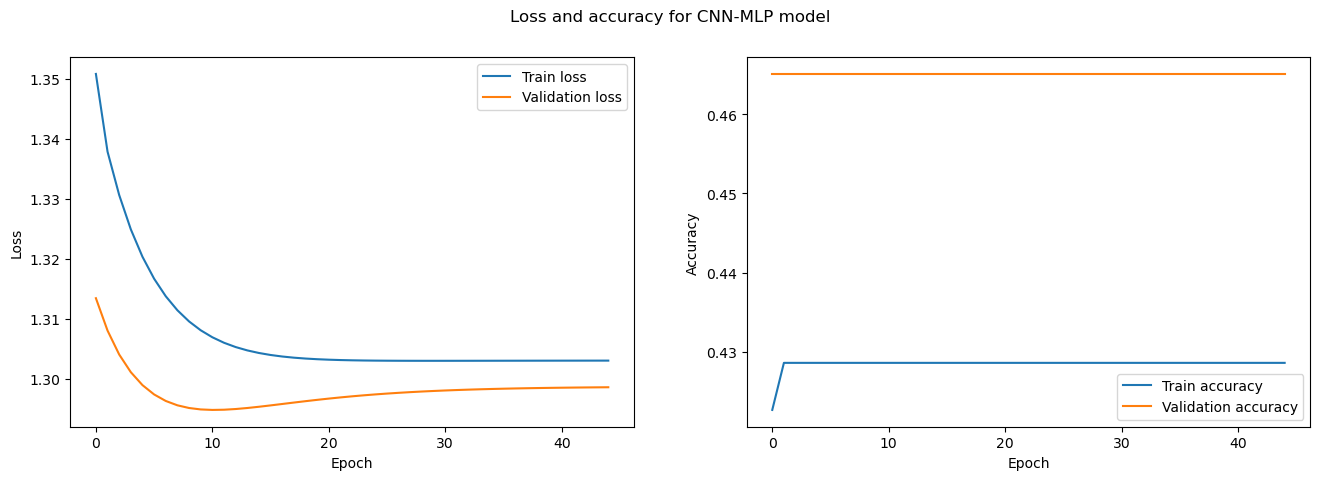

In [14]:

fig = plt.figure(figsize = plt.figaspect(0.3))
fig.suptitle("Loss and accuracy for CNN-MLP model")
        
ax = fig.add_subplot(1,2,1)
ax.plot(hist.history['loss'], label='Train loss')
ax.plot(hist.history['val_loss'], label = 'Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


ax = fig.add_subplot(1,2,2)
ax.plot(hist.history['accuracy'], label='Train accuracy')
ax.plot(hist.history['val_accuracy'], label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

In [16]:

#model.evaluate(test, steps=len(df_test)/batchSIZE, verbose=1)

# Only smallest and largest diameter

In [23]:
print('Collecting data from {}:'.format(str(data_base_dir)))
train_files = list((data_base_dir / 'Raw_images').glob('*.png'))


mask_files = list()
for _f in train_files:
    _mf = data_base_dir / str(_f).replace("raw", "segmentation").replace("Raw_images", "segmentation_images")
    
    mask_files.append(_mf)
    

print('  … collected {} samples.'.format(len(train_files)))


os.chdir(Path_to_folder)
df_variable_information = pd.read_csv('Finished_annotations_depth_information.csv')

#HERE YOU LOOP THROUGH LIKE BEFORE AND GET THE LABEL!
def assign_class(size):
    if size == '0-5 mm':
        return 0
    elif size == '6-9 mm':
        return 1
    elif size == '10-19 mm':
        return 2
    else:
        return 3
    

label_files = list()
patient_id_list = list()
polyp_num_list = list()




for _f in train_files: 
    filename = os.path.basename(_f)
    parts = filename.split("_")
    patient_id = int(parts[1])
    P_x = parts[2]
    polyp_num = int(P_x[1:])
    patient_id_list.append(patient_id)
    polyp_num_list.append(polyp_num)
    
    
    filter_condition = (df_variable_information['Patient ID'] == patient_id) & (df_variable_information['Polyp'] == polyp_num)
    #label_OC = df_variable_information.loc[filter_condition, 'OC Morphology'].values[0]
    label_value = df_variable_information.loc[filter_condition, 'class'].values[0]
    label_value = assign_class(label_value)
    
    label_files.append(label_value)
    

    
    
print(len(label_files), len(train_files), len(mask_files))

# Splitting the data set
df = pd.DataFrame(data={"filename": [str(_f) for _f in train_files], 'mask': [str(_f) for _f in mask_files], 'label': [str(_f) for _f in label_files],
                        'Patient ID': [_f for _f in patient_id_list],'Polyp': [_f for _f in polyp_num_list]})
df_train, df_test = train_test_split(df, test_size=0.1)
df_train, df_val = train_test_split(df_train, test_size=0.2)


#%% Creating df with variables for both train, val and test
df_Columns = df_variable_information[['Patient ID', 'Polyp', 'Largest diameter', 'Smallest diameter']]


df_train_variables = pd.merge(df_train, df_Columns, on = ['Patient ID', 'Polyp'], how = 'inner')
df_train_variables = df_train_variables.drop(columns = ['filename', 'mask', 'Patient ID', 'Polyp'])

df_val_variables = pd.merge(df_val, df_Columns, on = ['Patient ID', 'Polyp'], how = 'inner')
df_val_variables = df_val_variables.drop(columns = ['filename', 'mask', 'Patient ID', 'Polyp'])

df_test_variables = pd.merge(df_test, df_Columns, on = ['Patient ID', 'Polyp'], how = 'inner')
df_test_variables = df_test_variables.drop(columns = ['filename', 'mask', 'Patient ID', 'Polyp'])

  … collected 235 samples.
235 235 235


In [24]:
train_gen = train_generator(df_train, batchSIZE, train_generator_args,
                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                            augment=augment_training_data)

valid_gen = train_generator(df_val, batchSIZE,
                            dict(),
                            target_size=(IMG_HEIGHT, IMG_WIDTH))

test_gen = train_generator(df_test, batchSIZE,
                            dict(),
                            target_size=(IMG_HEIGHT, IMG_WIDTH))


df_train_variables_labels = np.array(df_train_variables['label'])
df_train_variables = df_train_variables.drop(columns = ['label'])
dataset_train = tf.data.Dataset.from_tensor_slices((df_train_variables.values, df_train_variables_labels))


df_val_variables_labels = np.array(df_val_variables['label'])
df_val_variables = df_val_variables.drop(columns = ['label'])
dataset_val = tf.data.Dataset.from_tensor_slices((df_val_variables.values, df_val_variables_labels))




df_test_variables_labels = np.array(df_test_variables['label'])
df_test_variables = df_test_variables.drop(columns = ['label'])
dataset_test = tf.data.Dataset.from_tensor_slices((df_test_variables.values, df_test_variables_labels))


xval_var, yval_label = next(dataset_val.as_numpy_iterator())



2023-05-27 18:51:52.467196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [43]
	 [[{{node Placeholder/_1}}]]


In [29]:

# create the MLP and CNN models
mlp = create_mlp(xval_var.shape[0] )#
cnn = create_cnn(526, 526, 3)
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="softmax")(combinedInput)
#x = Dense(1, activation="linear")(x)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)


dataset_train = tf.data.Dataset.from_tensor_slices(df_train_variables)
dataset_train = dataset_train.batch(batchSIZE)

dataset_val = tf.data.Dataset.from_tensor_slices(df_val_variables)
dataset_val = dataset_val.batch(batchSIZE)


dataset_test = tf.data.Dataset.from_tensor_slices(df_test_variables)
dataset_test = dataset_val.batch(batchSIZE)


def your_generator_batched(attr, img, repeat=True):
    # We need to provide data for multiple epochs
    while repeat:
        combined = zip(attr, img)
        for row, (xtrain_var, ytrain_label) in combined:
            yield {"dense_24_input": row,
                   "input_4": xtrain_var}, \
                  ytrain_label

gen = your_generator_batched(dataset_train, train_gen)
val = your_generator_batched(dataset_val, valid_gen)
test = your_generator_batched(dataset_test, test_gen)


In [30]:

model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=['accuracy'])
# train the model
print("[INFO] training model...")
hist = model.fit(gen,
    #x=[xtrain_var, x_img], y=x_mask,
    steps_per_epoch=len(df_train) / batchSIZE,
    validation_data=val,
    validation_steps=len(df_val) / batchSIZE,
    epochs=epochs, batch_size=batchSIZE)



[INFO] training model...
Epoch 1/45


2023-05-27 18:52:48.676357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [168,2]
	 [[{{node Placeholder/_0}}]]
2023-05-27 18:52:48.806214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


56/56 [==============================] - ETA: 0s - loss: 1.4094 - accuracy: 0.1667Found 43 validated image filenames belonging to 4 classes.


2023-05-27 18:53:42.550057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [43,2]
	 [[{{node Placeholder/_0}}]]
2023-05-27 18:53:42.584136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


56/56 [==============================] - 55s 966ms/step - loss: 1.4094 - accuracy: 0.1667 - val_loss: 1.3681 - val_accuracy: 0.2093
Epoch 2/45
56/56 [==============================] - 53s 956ms/step - loss: 1.3973 - accuracy: 0.2143 - val_loss: 1.3393 - val_accuracy: 0.4651
Epoch 3/45
56/56 [==============================] - 53s 953ms/step - loss: 1.3697 - accuracy: 0.4286 - val_loss: 1.3197 - val_accuracy: 0.4651
Epoch 4/45
56/56 [==============================] - 53s 952ms/step - loss: 1.3507 - accuracy: 0.4286 - val_loss: 1.3065 - val_accuracy: 0.4651
Epoch 5/45
56/56 [==============================] - 53s 955ms/step - loss: 1.3373 - accuracy: 0.4286 - val_loss: 1.2977 - val_accuracy: 0.4651
Epoch 6/45
56/56 [==============================] - 53s 956ms/step - loss: 1.3279 - accuracy: 0.4286 - val_loss: 1.2921 - val_accuracy: 0.4651
Epoch 7/45
56/56 [==============================] - 53s 955ms/step - loss: 1.3212 - accuracy: 0.4286 - val_loss: 1.2885 - val_accuracy: 0.4651
Epoch 8/45

In [31]:
Path_to_save= HOME / 'CNN_model_weights'
os.chdir(Path_to_save)
model.save('CNN_MLP_model_few_variables')



2023-05-27 19:33:13.138706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,263,263,64]
	 [[{{node inputs}}]]
2023-05-27 19:33:13.155160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,65,65,128]
	 [[{{node inputs}}]]
2023-05-27 19:33:13.166019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,32,32,128]
	 [[{{node inputs}}

INFO:tensorflow:Assets written to: CNN_MLP_model_few_variables/assets


INFO:tensorflow:Assets written to: CNN_MLP_model_few_variables/assets


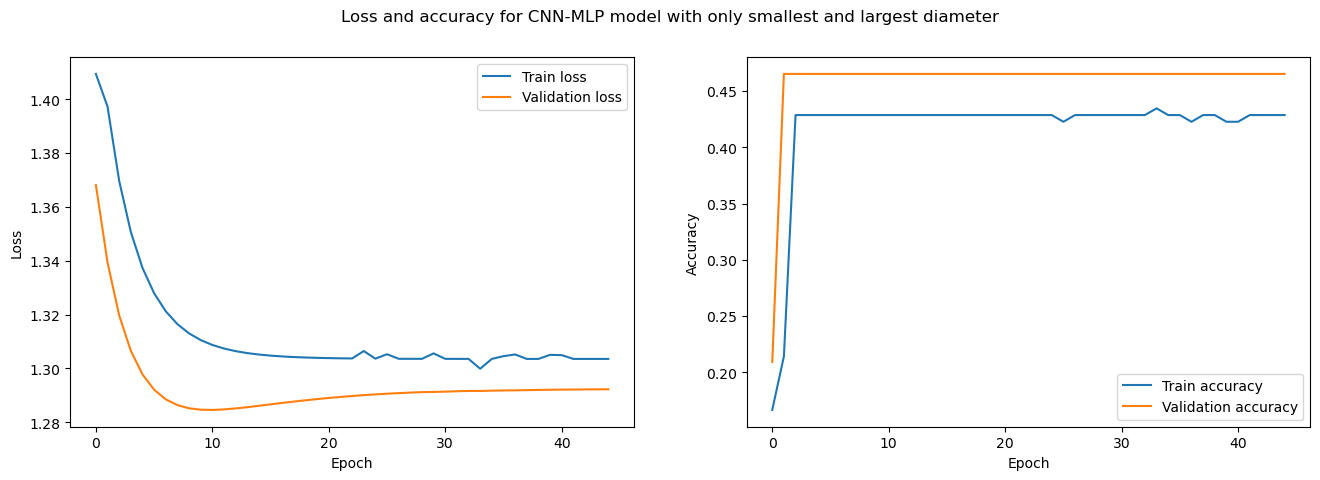

In [32]:

fig = plt.figure(figsize = plt.figaspect(0.3))
fig.suptitle("Loss and accuracy for CNN-MLP model with only smallest and largest diameter")
        
ax = fig.add_subplot(1,2,1)
ax.plot(hist.history['loss'], label='Train loss')
ax.plot(hist.history['val_loss'], label = 'Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


ax = fig.add_subplot(1,2,2)
ax.plot(hist.history['accuracy'], label='Train accuracy')
ax.plot(hist.history['val_accuracy'], label = 'Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.show()